In [43]:
#necessary imports
from termcolor import colored

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dense


# Compare the two inputs
def comparator(learner, instructor):
    if len(learner) != len(instructor):
        raise AssertionError(f"The number of layers in the model is incorrect. Expected: {len(instructor)} Found: {len(learner)}") 
    for a, b in zip(learner, instructor):
        if tuple(a) != tuple(b):
            print(colored("Test failed", attrs=['bold']),
                  "\n Expected value \n\n", colored(f"{b}", "green"), 
                  "\n\n does not match the input value: \n\n", 
                  colored(f"{a}", "red"))
            raise AssertionError("Error in test") 
    print(colored("All tests passed!", "green"))

# extracts the description of a given model
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        result.append(descriptors)
    return result

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [45]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/Alpaca/dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


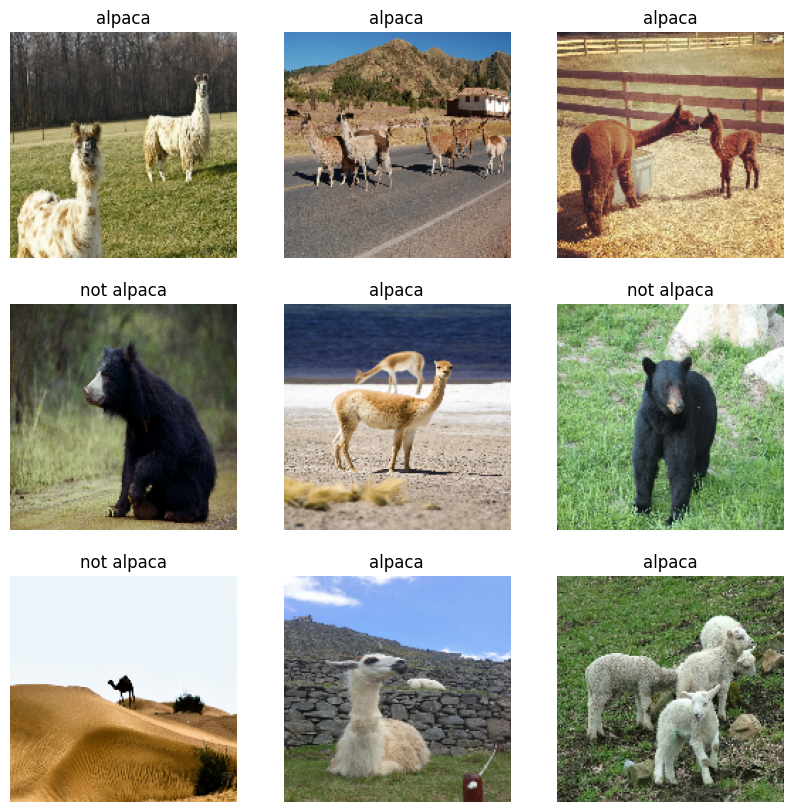

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [7]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')

All tests passed!


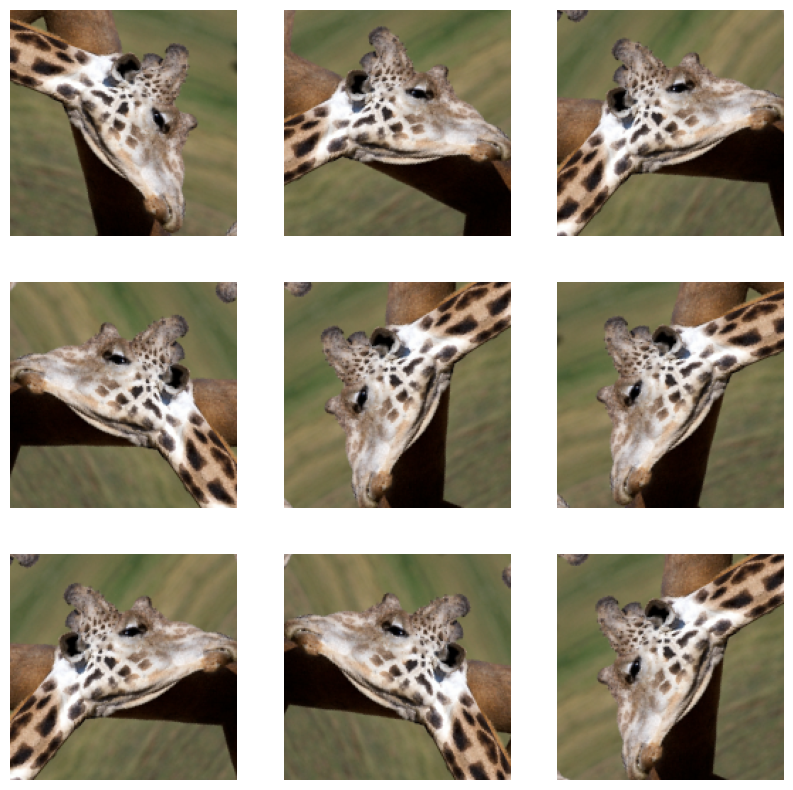

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [12]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [14]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [15]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.42582163),
  ('n02708093', 'analog_clock', 0.092755675)],
 [('n04589890', 'window_screen', 0.23985945),
  ('n03887697', 'paper_towel', 0.14802651)],
 [('n04589890', 'window_screen', 0.7449457),
  ('n03598930', 'jigsaw_puzzle', 0.021948567)],
 [('n04589890', 'window_screen', 0.3354602),
  ('n03530642', 'honeycomb', 0.07628971)],
 [('n04589890', 'window_screen', 0.2732742),
  ('n03733281', 'maze', 0.08846927)],
 [('n04589890', 'window_screen', 0.6745237),
  ('n03530642', 'honeycomb', 0.076599084)],
 [('n04589890', 'window_screen', 0.7912854),
  ('n04209239', 'shower_curtain', 0.092416056)],
 [('n04589890', 'window_screen', 0.16462995),
  ('n03598930', 'jigsaw_puzzle', 0.08749132)],
 [('n03598930', 'jigsaw_puzzle', 0.37021285),
  ('n04589890', 'window_screen', 0.09956944)],
 [('n04589890', 'window_screen', 0.616165),
  ('n03887697', 'paper_towel', 0.054876428)],
 [('n03530642', 'honeycomb', 0.25448847),
  ('n04589890', 'window_screen', 0.24874288)],
 [('

In [16]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    # Already Done -> preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)
    
    ### END CODE HERE
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [30]:

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
 ['Sequential', (None, 160, 160, 3), 0],
 ['TFOpLambda', (None, 160, 160, 3), 0],
 ['TFOpLambda', (None, 160, 160, 3), 0],
 ['Functional', (None, 5, 5, 1280), 2257984],
 ['GlobalAveragePooling2D', (None, 1280), 0],
 ['Dropout', (None, 1280), 0, 0.2],
 ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation
comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)
    
    

All tests passed!
['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TFOpLambda', (None, 160, 160, 3), 0]
['TFOpLambda', (None, 160, 160, 3), 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


In [32]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 21s 1s/step - loss: 0.8394 - accuracy: 0.4618 - val_loss: 0.7076 - val_accuracy: 0.6000
Epoch 2/5
9/9 [==============================] - 10s 815ms/step - loss: 0.7010 - accuracy: 0.5840 - val_loss: 0.5831 - val_accuracy: 0.6154
Epoch 3/5
9/9 [==============================] - 11s 820ms/step - loss: 0.5622 - accuracy: 0.6718 - val_loss: 0.4605 - val_accuracy: 0.7077
Epoch 4/5
9/9 [==============================] - 11s 976ms/step - loss: 0.5114 - accuracy: 0.7290 - val_loss: 0.4227 - val_accuracy: 0.7385
Epoch 5/5
9/9 [==============================] - 10s 824ms/step - loss: 0.4815 - accuracy: 0.7176 - val_loss: 0.3572 - val_accuracy: 0.7846


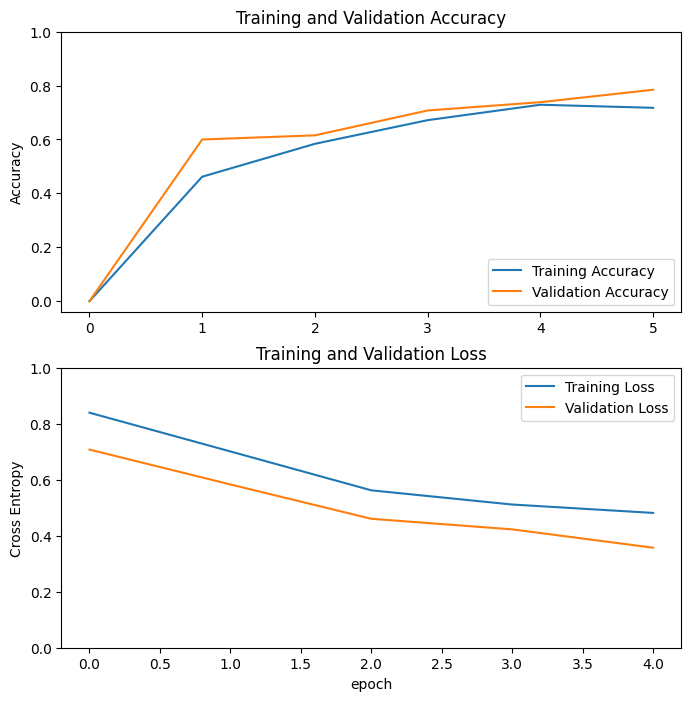

In [34]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
class_names

['alpaca', 'not alpaca']

In [36]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [38]:
assert type(loss_function) == tf.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')


All tests passed!


In [39]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 27s 2s/step - loss: 0.6194 - accuracy: 0.6718 - val_loss: 0.4868 - val_accuracy: 0.7846
Epoch 6/10
9/9 [==============================] - 13s 1s/step - loss: 0.3804 - accuracy: 0.8206 - val_loss: 0.2069 - val_accuracy: 0.9538
Epoch 7/10
9/9 [==============================] - 14s 1s/step - loss: 0.3101 - accuracy: 0.8779 - val_loss: 0.2170 - val_accuracy: 0.8769
Epoch 8/10
9/9 [==============================] - 14s 1s/step - loss: 0.2273 - accuracy: 0.9084 - val_loss: 0.1268 - val_accuracy: 0.9692
Epoch 9/10
9/9 [==============================] - 13s 1s/step - loss: 0.1532 - accuracy: 0.9504 - val_loss: 0.0955 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 14s 1s/step - loss: 0.1068 - accuracy: 0.9504 - val_loss: 0.0793 - val_accuracy: 0.9692


In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

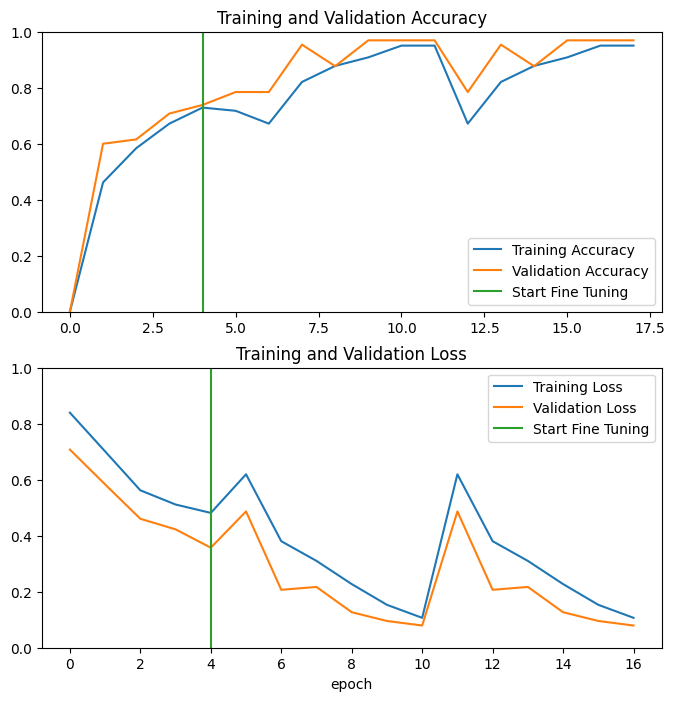

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()